In [0]:
import tensorflow as tf
import os
import numpy as np
import json
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.collections import PatchCollection
import cv2 as cv
from skimage import io
from skimage.segmentation import quickshift
import glob
import seaborn as sns

In [0]:
import os
import glob
import zipfile
import functools
from skimage import io
from skimage.segmentation import quickshift
import glob
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.model_selection import train_test_split
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import cv2 as cv

In [0]:
%matplotlib inline

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}



In [5]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
PATH="drive/inter_iit/conv_data"
img_dir = os.path.join(PATH, "sat")
label_dir = os.path.join(PATH, "gt")

In [0]:
def scale_percentile(matrix):
    """Fixes the pixel value range to 2%-98% original distribution of values"""
    orig_shape = matrix.shape
    matrix = np.reshape(matrix, [matrix.shape[0]*matrix.shape[1], 3]).astype(float)
    
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    
    matrix = (matrix - mins[None,:])/maxs[None,:]
    matrix = np.reshape(matrix, orig_shape)
    matrix = matrix.clip(0,1)
    return matrix

def scale_percentile_without_normalization(matrix):
    """Fixes the pixel value range to 2%-98% original distribution of values"""
    orig_shape = matrix.shape
    matrix = np.reshape(matrix, [matrix.shape[0]*matrix.shape[1], 3]).astype(float)
    
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    
    matrix = (matrix - mins[None,:])/maxs[None,:]
    matrix = np.reshape(matrix, orig_shape)
    #matrix = matrix.clip(0,1)
    return matrix
def stretch_8bit(bands, lower_percent=2, higher_percent=98):
    out = np.z|eros_like(bands).astype(np.float32)
    for i in range(3):
        a = 0
        b = 1
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t
    return out.astype(np.float32)

In [8]:
'''
mypath = 'drive/inter_iit/conv_data/gt'
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
sz=(1024,1024)
for n in range(0, len(onlyfiles)):
    
    fname=os.path.join(label_dir, "{}.png".format(n))
    os.remove(fname)
    print(n)

  '''  

'\nmypath = \'drive/inter_iit/conv_data/gt\'\nonlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]\nsz=(1024,1024)\nfor n in range(0, len(onlyfiles)):\n    \n    fname=os.path.join(label_dir, "{}.png".format(n))\n    os.remove(fname)\n    print(n)\n\n  '

In [9]:
'''
mypath2 = 'drive/inter_iit/conv_data/sat'
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath2, f))]
sz=(1024,1024)
for n in range(0, len(onlyfiles)):
    
    fname=os.path.join(img_dir, "{}.png".format(n))
    os.remove(fname)
    print(n)
    
'''


'\nmypath2 = \'drive/inter_iit/conv_data/sat\'\nonlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath2, f))]\nsz=(1024,1024)\nfor n in range(0, len(onlyfiles)):\n    \n    fname=os.path.join(img_dir, "{}.png".format(n))\n    os.remove(fname)\n    print(n)\n    \n'

In [10]:
'''
mypath = 'drive/inter_iit/The-Eye-in-the-Sky-dataset/gt'
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
sz=(1024,1024)


images = []
for n in range(0, len(onlyfiles)):
    im = io.imread(os.path.join(mypath, onlyfiles[n]))
    fname=os.path.join(label_dir, "{}.png".format(n))
    plt.imsave(fname, im)
    im=resize(im, sz)#.reshape(-1)
    images.append(im)
    print(im.shape)
    #df2 = pd.DataFrame(im.reshape(-1))
    #df = pd.concat([df, df2], axis=1, ignore_index=True)
    k = k + 1
    print(k)
#print(df)


   
images_gt = np.asarray(images)

print(images_gt.shape)
   


'''

'\nmypath = \'drive/inter_iit/The-Eye-in-the-Sky-dataset/gt\'\nonlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]\nsz=(1024,1024)\n\n\nimages = []\nfor n in range(0, len(onlyfiles)):\n    im = io.imread(os.path.join(mypath, onlyfiles[n]))\n    fname=os.path.join(label_dir, "{}.png".format(n))\n    plt.imsave(fname, im)\n    im=resize(im, sz)#.reshape(-1)\n    images.append(im)\n    print(im.shape)\n    #df2 = pd.DataFrame(im.reshape(-1))\n    #df = pd.concat([df, df2], axis=1, ignore_index=True)\n    k = k + 1\n    print(k)\n#print(df)\n\n\n   \nimages_gt = np.asarray(images)\n\nprint(images_gt.shape)\n   \n\n\n'

In [11]:

  '''
  mypath = 'drive/inter_iit/The-Eye-in-the-Sky-dataset/sat'
  onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]


  images_sat = []

  for n in range(0, len(onlyfiles)):
      im = io.imread(os.path.join(mypath, onlyfiles[n]))
      im_rgb=im[...,0:3]

      fixed_im = scale_percentile(im_rgb)
      im=fixed_im
      print(fixed_im.shape)
      fname=os.path.join(img_dir, "{}.png".format(n))
      plt.imsave(fname, fixed_im)
      im=resize(im, sz)#.reshape(-1)

      images_sat.append(im)
      print(im.shape)
      #df2 = pd.DataFrame(im.reshape(-1))
      #df = pd.concat([df, df2], axis=1, ignore_index=True)

      print(n)
  #print(df)

  images_sat = np.asarray(images_sat)
  print(images_sat[2])

  print(images_sat.shape)

  '''


'\nmypath = \'drive/inter_iit/The-Eye-in-the-Sky-dataset/sat\'\nonlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]\n\n\nimages_sat = []\n\nfor n in range(0, len(onlyfiles)):\n    im = io.imread(os.path.join(mypath, onlyfiles[n]))\n    im_rgb=im[...,0:3]\n    \n    fixed_im = scale_percentile(im_rgb)\n    im=fixed_im\n    print(fixed_im.shape)\n    fname=os.path.join(img_dir, "{}.png".format(n))\n    plt.imsave(fname, fixed_im)\n    im=resize(im, sz)#.reshape(-1)\n    \n    images_sat.append(im)\n    print(im.shape)\n    #df2 = pd.DataFrame(im.reshape(-1))\n    #df = pd.concat([df, df2], axis=1, ignore_index=True)\n    \n    print(n)\n#print(df)\n   \nimages_sat = np.asarray(images_sat)\nprint(images_sat[2])\n\nprint(images_sat.shape)\n\n'

In [12]:
mypath = 'drive/inter_iit/conv_data/gt'
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
sz=(1024,1024)


images = []
for n in range(0, len(onlyfiles)):
    im = io.imread(os.path.join(mypath, onlyfiles[n]))[...,0:3]
    fname=os.path.join(label_dir, "{}.png".format(n))
    #plt.imsave(fname, im)
    im=resize(im, sz)#.reshape(-1)
    images.append(im)
    print(im.shape)
    #df2 = pd.DataFrame(im.reshape(-1))
    #df = pd.concat([df, df2], axis=1, ignore_index=True)
    n
#print(df)


   
images_gt = np.asarray(images)

print(images_gt.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(24, 1024, 1024, 3)


In [13]:
mypath = 'drive/inter_iit/conv_data/sat'
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]


images_sat = []

for n in range(0, len(onlyfiles)):
    im = io.imread(os.path.join(mypath, onlyfiles[n]))[...,0:3]
    
    
    im=resize(im, sz)#.reshape(-1)
    
    images_sat.append(im)
    print(im.shape)
    n
    

images_sat = np.asarray(images_sat)
print(images_sat[2])

print(images_sat.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
[[[0.0780596  0.09597812 0.12605006]
  [0.13318869 0.14711907 0.16948043]
  [0.21462449 0.23726169 0.24697016]
  ...
  [0.11128369 0.1422255  0.25981129]
  [0.14078585 0.16406589 0.27413067]
  [0.16431526 0.19019991 0.29417431]]

 [[0.17941    0.21360456 0.22587287]
  [0.16714448 0.21210009 0.22563851]
  [0.25748257 0.29951746 0.29942526]
  ...
  [0.0915596  0.13973477 0.30901164]
  [0.10933051 0.15130163 0.31215032]
  [0.13661358 0.18099975 0.33219504]]

 [[0.26693779 0.31907484 0.31441606]
  [0.27942754 0.34570741 0.3381403 ]
  [0.34221722 0.39680324 0.38045729]
  ...
  [0.08266889 0.14935853 0.36444069]
  [0.08812794 0.15276326 0.37056188]
  [0.09427083 0.1597233  0.37403493]]

 ...

 [[0.13375278 0.13260398 0.17625632]
  [0.1431097  0.13339931 0.18426894]
  [0.1

In [14]:
df_x = pd.DataFrame.from_records(images_sat)
df_y = pd.DataFrame.from_records(images_gt)
print(images_sat[2].shape)


(1024, 1024, 3)


In [15]:
x_train_filenames = []
y_train_filenames = []
for index in range( 14):
  
  x_train_filenames.append(os.path.join(img_dir, "{}.png".format(index)))
  y_train_filenames.append(os.path.join(label_dir, "{}.png".format(index)))
  #print(index)

print(len(x_train_filenames))  

14


(1001, 1068, 3)
(1146, 872, 3)
(926, 943, 3)
(1295, 1364, 3)
(622, 782, 3)


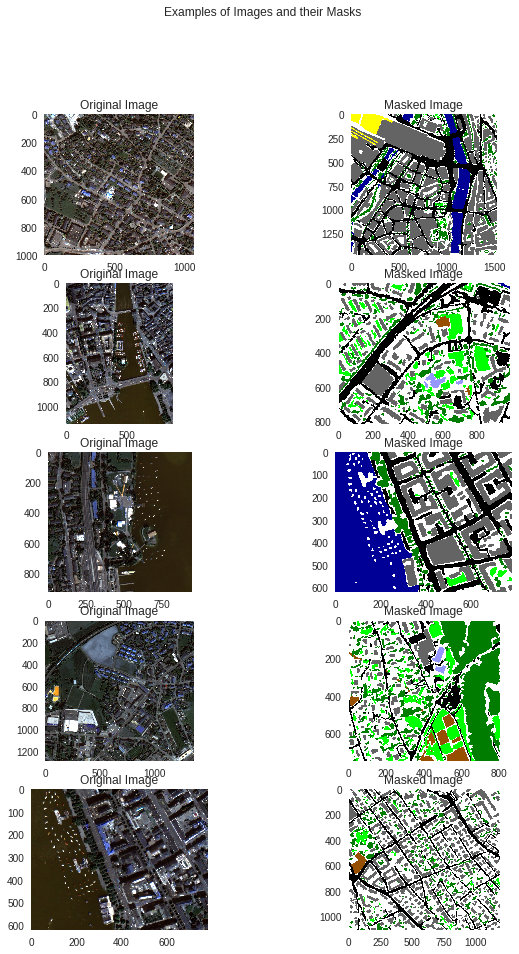

In [16]:

display_num = 5
nu=len(x_train_filenames)


plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  print(io.imread(x_train_filenames[img_num])[...,0:3].shape)
  plt.imshow((io.imread(x_pathname)[...,0:3]))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(example_labels)
  #print(np.unique(io.imread(y_train_filenames[img_num])))
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [0]:
y,x=0,0
h,w=256,256


img=images_sat[1]
crop_img = img[y:y+h, x:x+w]

In [0]:
PATH="drive/inter_iit/split_data"
img_dir = os.path.join(PATH, "sat")
label_dir = os.path.join(PATH, "gt")

In [49]:

h,w=256,256

split_sat=[]
split_gt=[]


for i in range(0, 14):
  
  img_num=i
  x,y=0,0
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  im_sat=io.imread(x_pathname)[...,0:3]
  im_gt=io.imread(y_pathname)
  n=i
  print(i)
  while 1:
    x=0
    while 1:
      fname_lab=os.path.join(label_dir, "{}_{}_{}.png".format(n,x,y))
      fname_img=os.path.join(img_dir, "{}_{}.png".format(n,x,y))
      crop_img_x = im_sat[y:y+h, x:x+w].flatten()
      df1=pd.DataFrame(crop_img_x)
      
      #plt.imsave(fname_img,crop_img_x)
      split_sat.append(crop_img_x)

      crop_img_y = im_gt[y:y+h, x:x+w].flatten()
      df2=pd.DataFrame(crop_img_y)
     #plt.imsave(fname_lab,crop_img_y)
      split_gt.append(crop_img_y)
      if(i==0):
        df_sat=pd.DataFrame(crop_img_x)
        df_gt=pd.DataFrame(crop_img_y)
        
      else:
        df_sat= pd.concat([df_sat, df1], axis=0, ignore_index=True)
        df_gt= pd.concat([df_gt, df2], axis=0, ignore_index=True)
      x=x+40
      
      if(x>=750):
        break
    y=y+40
    if(y>=750):
      break
      
    
  
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [0]:
split_sat = np.asarray(split_sat)
split_gt = np.asarray(split_gt)

In [34]:
print(split_sat[0:2:3])

[array([ 95,  92, 103, ...,  73,  83,  92], dtype=uint8)]


In [0]:

df_x = pd.DataFrame(split_sat)
df_y = pd.DataFrame(split_gt)
print(df_x[1].shape)


In [46]:
print(df_x[0:1].values
     )

[[array([ 95,  92, 103, ...,  73,  83,  92], dtype=uint8)]]


In [232]:
trainX = df_x.values.reshape(5054,3,256, 256).astype( 'float32' )

ValueError: ignored

In [0]:

df_y.to_csv('dfy.csv')

In [0]:

img_shape = (256, 256, 3)
batch_size = 64
epochs = 5

In [0]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.read_file(fname)
  img = tf.image.decode_jpeg(img_str, channels=3)

  label = tf.read_file(label_path)
  # These are gif images so they return as (num_frames, h, w, c)
  label_img = io.imread(label_path)
  nx = label_img.shape[1]
  ny = label_img.shape[0]
  labels = np.zeros((256, 256, 6), dtype=np.float32)
  labels[..., 5] = (label==255).astype(int)
  labels[..., 4] = (label==150).astype(int)
  labels[..., 3] = (label==125).astype(int)
  labels[..., 2] = (label==100).astype(int)
  labels[..., 1] = (label==80).astype(int)
  labels[..., 0] = (label==0).astype(int)

  # The label image should only have values of 1 or 0, indicating pixel wise
  # object (car) or not (background). We take the first channel only. 
  #label_img = label_img[:, :, 0]
  #label_img = tf.expand_dims(label_img, axis=-1)
  return img, labels

In [0]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  """This fn will perform the horizontal or vertical shift"""
  if width_shift_range or height_shift_range:
      if width_shift_range:
        width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
      if height_shift_range:
        height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
      # Translate both 
      output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
      label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
  return output_img, label_img

In [0]:
def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

In [0]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)
  
  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)
  
  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  label_img = tf.to_float(label_img) * scale
  img = tf.to_float(img) * scale 
  return img, label_img


In [0]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

In [0]:

tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)



In [0]:
img,label=_process_pathnames((x_train_filenames[1]),(y_train_filenames[1]))
print(label.shape)
#plt.imshow(io.imread(y_train_filenames[1])[...,0:3])
print (label)
print(img.shape)
print(img)

In [0]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [0]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

In [0]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  print(label.shape)
  print(label)
  plt.imshow(label[0, :, :, :])
  plt.show()

In [0]:
x_train, x_val, y_train, y_val= train_test_split(df_x.values, df_y.values, test_size=0.3, random_state=42)

In [211]:
print(x_train.shape)

(3537, 256)


In [212]:
x_train[:, 1:].reshape(3537,3,256,256)

ValueError: ignored

In [0]:

from __future__ import division

import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Cropping2D

from keras import backend as K

import keras
import h5py

from keras.layers.normalization import BatchNormalization


from keras.optimizers import Nadam
from keras.callbacks import History
import pandas as pd
from keras.backend import categorical_crossentropy

import datetime
import os

import random
import threading
from tensorflow.python.keras import layers
from keras.models import model_from_json
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
from keras import utils

In [0]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [203]:
inputs = layers.Input(shape=img_shape)

# 256
print(inputs.shape)
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
print(encoder0_pool.shape)
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)

#encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(decoder0)






(?, 256, 256, 3)
(?, 128, 128, 32)


In [0]:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [0]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


In [0]:
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + categorical_crossentropy(y_pred, y_true)

In [0]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

In [0]:
save_model_path = 'drive/inter_iit/model/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [0]:
epochs=5
batch_size=64

In [0]:
history = model.fit(x_train, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=x_val,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

In [0]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [0]:
# Alternatively, load the weights directly: model.load_weights(save_model_path)
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

In [0]:

# Let's visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0]

  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, :])
  plt.title("Actual Mask")
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[:, :, :])
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()